In [196]:
# Import Modules
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling tools
import statsmodels.api as sm

import lightgbm as lgb

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, confusion_matrix, auc, roc_auc_score, roc_curve

%matplotlib inline
plt.style.use('dark_background')

%load_ext autoreload
%autoreload 2

pd.set_option('display.min_row', 25)
pd.set_option('display.max_column', 100)
pd.set_option('display.max_colwidth', 300)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
streets = pd.read_csv('../data/Seattle_Streets.csv', index_col='OBJECTID')
intersections = pd.read_csv('../data/Intersections.csv')

### Data Clean the Collisions Data

In [86]:
collisions = pd.read_csv('../data/processed/feateng_collisions.csv', low_memory=False)
collisions.head()

,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,1787335,Matched,Intersection,29797.0,BROADWAY AND CHERRY ST,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3279003.0,NaN,NaN,NaN,0,0,N,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
1,2004-01-01 00:00:00,-122.316863,47.615847,18457,32216,32216,1775182,Matched,Block,NaN,12TH AVE BETWEEN E PINE ST AND E OLIVE ST,NaN,NaN,1,Property Damage Only Collision,Other,5,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),16.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE SIDESWIPE",NaN,0,Raining,Dry,Dark - Street Lights On,NaN,4001022.0,NaN,23,From same direction - all others,0,0,N,"(47.6158466942628, -122.31686348709101)",0.008300,1.251186,0.073032,0.034031
2,2004-01-01 00:00:00,0.000000,0.000000,18014,31860,31860,1789485,Matched,Block,NaN,AURORA AVE N BETWEEN BATTERY ST TUNNEL NB AND THOMAS ST,NaN,NaN,2,Injury Collision,Rear Ended,4,0,0,3,1,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Wet,Dark - Street Lights On,NaN,4001017.0,Y,13,From same direction - both going straight - both moving - rear-end,0,0,N,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
3,2004-01-01 00:00:00,-122.314210,47.664908,10643,24534,24534,1780964,Matched,Intersection,25792.0,BROOKLYN AVE NE AND NE 50TH ST,NaN,NaN,2,Injury Collision,Left Turn,7,0,0,2,2,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,0,Raining,Wet,Daylight,NaN,4001023.0,NaN,28,From opposite direction - one left turn - one straight,0,0,N,"(47.6649084746288, -122.314210090723)",0.026256,1.345241,0.116098,0.005466
4,2004-01-01 00:00:00,-122.293643,47.721985,3443,16991,16991,1780749,Matched,Block,NaN,LAKE CITY WAY NE BETWEEN NE 127TH ST AND NE 130TH ST,NaN,NaN,2,Injury Collision,Rear Ended,2,0,0,2,1,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Raining,Wet,Daylight,NaN,4001005.0,NaN,14,From same direction - both going straight - one stopped - rear-end,0,0,N,"(47.721985407450894, -122.293642667672)",0.037611,0.198203,0.244040,0.059682


In [87]:
collisions = (collisions.sort_index().drop(columns=['EXCEPTRSNDESC', 'EXCEPTRSNCODE', 'REPORTNO', 'STATUS']))

In [88]:
collisions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220338 entries, 0 to 220337
Data columns (total 41 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Datetime           220338 non-null  object 
 1   X                  220338 non-null  float64
 2   Y                  220338 non-null  float64
 3   OBJECTID           220338 non-null  int64  
 4   INCKEY             220338 non-null  int64  
 5   COLDETKEY          220338 non-null  int64  
 6   ADDRTYPE           216632 non-null  object 
 7   INTKEY             71472 non-null   float64
 8   LOCATION           215763 non-null  object 
 9   SEVERITYCODE       220337 non-null  object 
 10  SEVERITYDESC       220338 non-null  object 
 11  COLLISIONTYPE      194186 non-null  object 
 12  PERSONCOUNT        220338 non-null  int64  
 13  PEDCOUNT           220338 non-null  int64  
 14  PEDCYLCOUNT        220338 non-null  int64  
 15  VEHCOUNT           220338 non-null  int64  
 16  IN

### Target Column: Severity Code

In [89]:
collisions.groupby(['SEVERITYCODE', 'SEVERITYDESC']).count()

,,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
SEVERITYCODE,SEVERITYDESC,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,Unknown,21509,21509,21509,21509,21509,21509,19733,4463,19623,1,21509,21509,21509,21509,21509,21509,21509,21509,15939,21508,21508,0,0,1,1,1,1,10205,0,12115,1,21509,21509,21509,21509,21509,21509,21509,21509
1,Property Damage Only Collision,136964,136964,136964,136964,136964,136964,135228,37381,134556,133330,136964,136964,136964,136964,136964,136964,136964,136964,131021,136964,136964,19410,133338,133192,133241,133110,464,81429,5847,136959,133330,136964,136964,136964,136964,136964,136964,136964,136964
2,Injury Collision,58441,58441,58441,58441,58441,58441,58250,27919,58168,57480,58441,58441,58441,58441,58441,58441,58441,58441,58039,58441,58441,10400,57492,57435,57461,57429,4229,33507,3561,58428,57480,58441,58441,58441,58441,58441,58441,58441,58441
2b,Serious Injury Collision,3077,3077,3077,3077,3077,3077,3074,1552,3069,3037,3077,3077,3077,3077,3077,3077,3077,3077,3059,3077,3077,361,3037,3031,3036,3030,430,1869,373,3077,3037,3077,3077,3077,3077,3077,3077,3077,3077
3,Fatality Collision,346,346,346,346,346,346,346,156,346,338,346,346,346,346,346,346,346,346,345,346,346,16,338,338,338,338,53,195,89,346,338,346,346,346,346,346,346,346,346


In [90]:
# replace 2b with 3 and 3 with 4 in order to change column into int type
collisions['SEVERITYCODE'].replace('3', '4', inplace=True)
collisions['SEVERITYCODE'].replace('2b', '3', inplace=True)

In [91]:
collisions['SEVERITYCODE'].value_counts()

1    136964
2     58441
0     21509
3      3077
4       346
Name: SEVERITYCODE, dtype: int64

In [92]:
# Severity code only contains one nan value and given that the severity desc is Unknown, the appropriate label is 0
collisions['SEVERITYCODE'].fillna(value=0, inplace=True)

In [93]:
collisions['SEVERITYCODE'] = collisions['SEVERITYCODE'].astype(int)

In [94]:
collisions[['SEVERITYCODE', 'INJURIES', 'SERIOUSINJURIES', 'FATALITIES']].corr()

,SEVERITYCODE,INJURIES,SERIOUSINJURIES,FATALITIES
SEVERITYCODE,1.000000,0.700327,0.280234,0.168116
INJURIES,0.700327,1.000000,0.279734,0.067403
SERIOUSINJURIES,0.280234,0.279734,1.000000,0.173780
FATALITIES,0.168116,0.067403,0.173780,1.000000


### Fill in numbers for records showing no people involvement even when there are vehicles

In [95]:
no_people = collisions.loc[(collisions['PEDCOUNT'] == 0) & 
           (collisions['PEDCYLCOUNT'] == 0) & 
           (collisions['PERSONCOUNT'] == 0) & 
            (collisions['VEHCOUNT'] == 0)]

people = collisions.loc[(collisions['PEDCOUNT'] != 0) | 
           (collisions['PEDCYLCOUNT'] != 0) | 
           (collisions['PERSONCOUNT'] != 0) | 
            (collisions['VEHCOUNT'] != 0)]

In [96]:
# Replace the values in no_people df and merge with original collisions set
veh_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('VEHICLE') if type(x) == str else 0)
ped_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('PEDESTRIAN') if type(x) == str else 0)
cyclist_count = no_people['SDOT_COLDESC'].apply(lambda x: x.count('PEDALCYCLIST') if type(x) == str else 0)

no_people.loc[:,'VEHCOUNT'] = veh_count
no_people.loc[:,'PEDCOUNT'] = ped_count
no_people.loc[:, 'PEDCYLCOUNT'] = cyclist_count

/Users/cindywong/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [97]:
# Merge the people and no_people dataframes
df = pd.concat([no_people, people])

In [98]:
df.head()

,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,3279003.0,NaN,NaN,NaN,0,0,N,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
10,2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,4001029.0,NaN,NaN,NaN,0,0,N,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
11,2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",NaN,NaN,NaN,NaN,NaN,NaN,4001027.0,NaN,NaN,NaN,0,0,N,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
16,2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,NaN,NaN,NaN,NaN,NaN,NaN,4001030.0,NaN,NaN,NaN,0,0,N,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
30,2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,NaN,NaN,NaN,NaN,NaN,4001028.0,NaN,NaN,NaN,0,0,N,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


### Binary Columns

In [99]:
# encode binary columns
binary_cols = ['SPEEDING', 'INATTENTIONIND', 'HITPARKEDCAR', 'PEDROWNOTGRNT']

for col in binary_cols:
    df[col] = df[col].apply(lambda x: 1 if x == 'Y' else 0)

In [100]:
df.head()

,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,1,3279003.0,0,NaN,NaN,0,0,0,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
10,2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,NaN,NaN,NaN,NaN,0,4001029.0,0,NaN,NaN,0,0,0,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
11,2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",0,NaN,NaN,NaN,NaN,0,4001027.0,0,NaN,NaN,0,0,0,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
16,2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,0,NaN,NaN,NaN,NaN,0,4001030.0,0,NaN,NaN,0,0,0,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
30,2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,NaN,NaN,NaN,NaN,0,4001028.0,0,NaN,NaN,0,0,0,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


### Under Influence Column

In [101]:
# presumably, it is either a yes or no. 
# NaN values is likely to be 0/N but it could also be that it was unclear at the time. Will change this to categorical instead
# map the rest of the values first and label NaN values as the 0 category

print(df['UNDERINFL'].value_counts(dropna=False))
df['UNDERINFL'] = df['UNDERINFL'].map({'Y':2, '1':2, 'N':1, '0':1})

N      102902
0       81676
NaN     26132
Y        5398
1        4230
Name: UNDERINFL, dtype: int64


In [102]:
df['UNDERINFL'].fillna(0, inplace=True)
df['UNDERINFL'] = df['UNDERINFL'].astype(int)
df['UNDERINFL'].value_counts(dropna=False)

1    184578
0     26132
2      9628
Name: UNDERINFL, dtype: int64

### Condition Columns

In [103]:
cond_cols = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'SEVERITYCODE']

for x in cond_cols:
    print(x, ':', '\n', df[x].value_counts())
    print('\n')

WEATHER : 
 Clear                       113939
Raining                      33961
Overcast                     28417
Unknown                      15131
Snowing                        919
Other                          849
Fog/Smog/Smoke                 576
Sleet/Hail/Freezing Rain       116
Blowing Sand/Dirt               56
Severe Crosswind                26
Partly Cloudy                    8
Name: WEATHER, dtype: int64


ROADCOND : 
 Dry               127675
Wet                48635
Unknown            15127
Ice                 1231
Snow/Slush          1014
Other                136
Standing Water       119
Sand/Mud/Dirt         77
Oil                   64
Name: ROADCOND, dtype: int64


LIGHTCOND : 
 Daylight                    118721
Dark - Street Lights On      49963
Unknown                      13515
Dusk                          6060
Dawn                          2583
Dark - No Street Lights       1571
Dark - Street Lights Off      1235
Other                          244
Dark - Unk

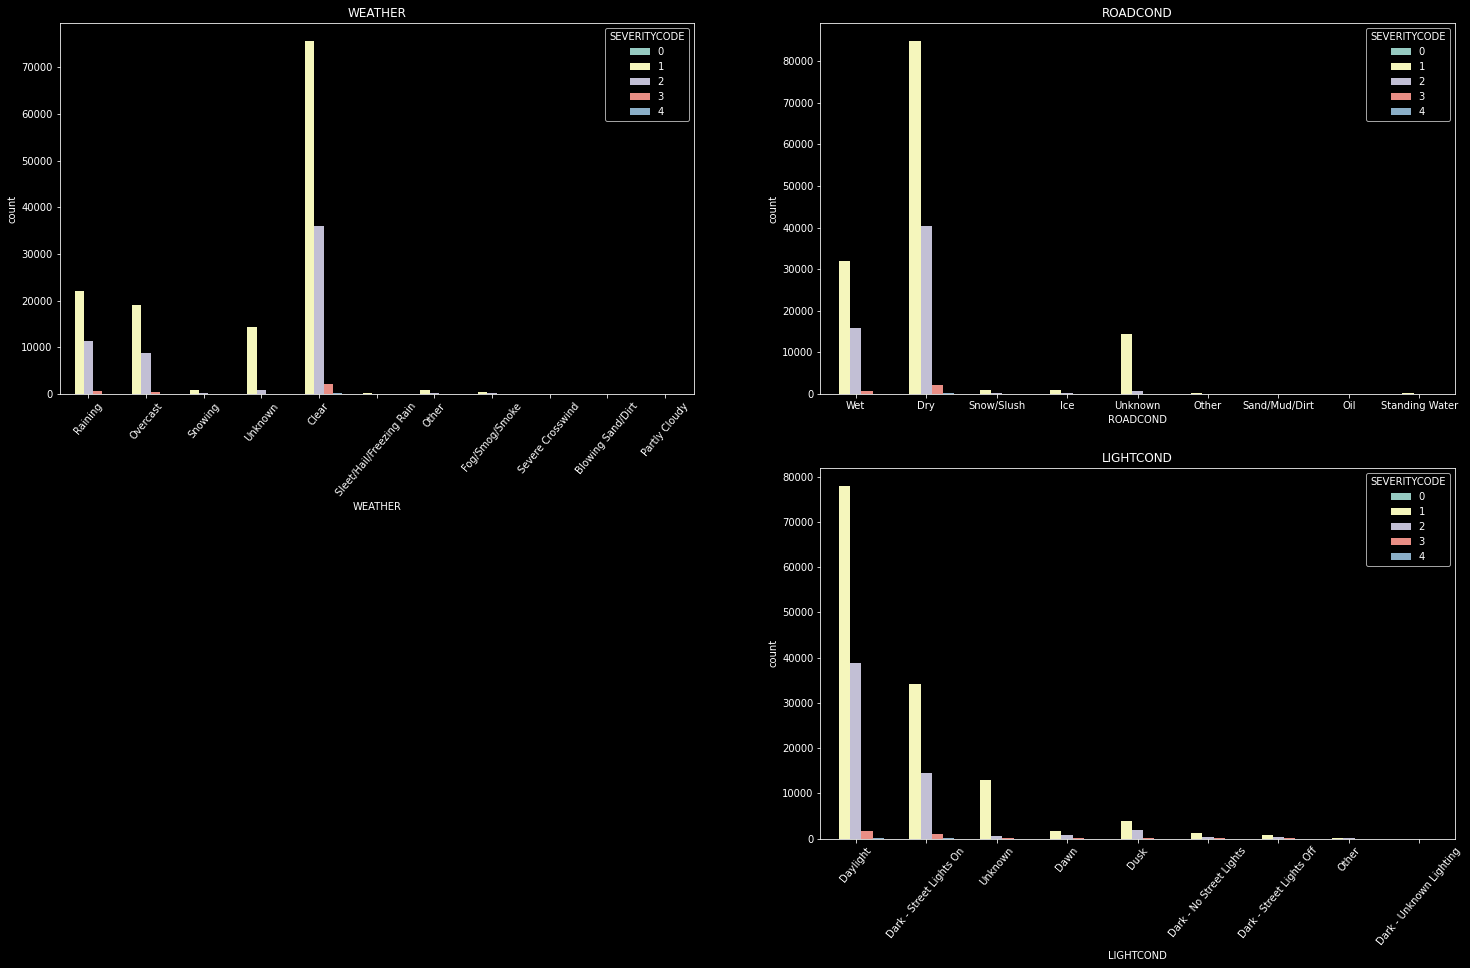

In [104]:
fig, axes = plt.subplots(2,2,figsize=(25,15))

ax1 = sns.countplot('WEATHER', hue='SEVERITYCODE', data=df, ax=axes[0][0])
axes[0][0].legend(title='SEVERITYCODE', loc='upper right')
axes[0][0].set_xticklabels(ax1.get_xticklabels(), rotation=50)
ax1.set_title('WEATHER');

ax2 = sns.countplot('ROADCOND', hue='SEVERITYCODE', data=df, ax=axes[0][1])
axes[0][1].legend(title='SEVERITYCODE', loc='upper right')
ax2.set_title('ROADCOND');

ax3 = sns.countplot('LIGHTCOND', hue='SEVERITYCODE', data=df, ax = axes[1][1])
axes[1][1].legend(title='SEVERITYCODE', loc='upper right')
axes[1][1].set_xticklabels(ax3.get_xticklabels(), rotation=50)
ax3.set_title('LIGHTCOND');


fig.delaxes(axes[1][0])
fig.tight_layout;

In [105]:
def encode_weather(x):
    '''
    One hot encodes the WEATHER column.
    
    Input: Pd.Series, WEATHER column
    Returns: OHE WEATHER column
    '''
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif (x == 'Clear'):
        return 1
    else:
        return 2    

def encode_road(x):
    '''
    One hot encodes the ROADCOND column.
    
    Input: Pd.Series, ROADCOND column
    Returns: OHE ROADCOND column
    '''
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif x == 'Dry':
        return 1
    else:
        return 2
    
def encode_light(x):
    '''
    One hot encodes the LIGHTCOND column. Choice of 'Dark- Unknown lighting' with the other dark conditions
    
    Input: Pd.Series, LIGHTCOND column
    Returns: OHE LIGHTCOND column
    '''
    
    if (x == 'Unknown') or (x == 'Other') or (x == 0):
        return 0
    elif x == 'Daylight':
        return 1
    elif (x == 'Dawn') or (x == 'Dusk') or (x == 'Dark - Street Lights On'):
        return 2
    else:
        return 3

In [106]:
# Encode weather, road, and light conditions. Nan is filled with 0 prior to OHE

for series, function in zip(['WEATHER', 'ROADCOND', 'LIGHTCOND'], 
                            [encode_weather, encode_road, encode_light]):
    df[series] = df[series].fillna(0).apply(function)
df.head()

,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,0,0,0,0,0,1,3279003.0,0,NaN,NaN,0,0,0,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
10,2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001029.0,0,NaN,NaN,0,0,0,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
11,2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",0,0,0,0,0,0,4001027.0,0,NaN,NaN,0,0,0,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
16,2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,NaN,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,0,0,0,0,0,0,4001030.0,0,NaN,NaN,0,0,0,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
30,2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001028.0,0,NaN,NaN,0,0,0,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


In [107]:
# columns with null values
df.columns[df.isnull().sum() > 0]

Index(['ADDRTYPE', 'INTKEY', 'LOCATION', 'COLLISIONTYPE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE',
       'ST_COLDESC'],
      dtype='object')

In [108]:
# most missing addrtype have many other columns missing values or states not enough information.
# will fill the null values in ADDRTYPE as unknown
df['ADDRTYPE'].fillna('Unknown', inplace=True)

In [109]:
# around 60% of the INTKEY is missing. will drop the column for now.
# LOCATION has too many unique categorical values. will drop.
# COLLISIONTYPE might be insightful. OHE?
# drop JUNCTIONTYPE for now since it is just more specific of ADDRTYPE
# drop ['SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 'ST_COLCODE', 'ST_COLDESC'] for too many different unique values


print('Percent missing in ADDRTYPE: ', (df['ADDRTYPE'].isnull().sum() / len(df['ADDRTYPE'])) * 100)
print('Percent missing in INTKEY: ', (df['INTKEY'].isnull().sum() / len(df['INTKEY'])) * 100)
print('Percent missing in LOCATION: ', (df['LOCATION'].isnull().sum() / len(df['LOCATION'])) * 100)
print('Percent missing in COLLISIONTYPE: ', (df['COLLISIONTYPE'].isnull().sum() / len(df['COLLISIONTYPE'])) * 100)
print('Percent missing in JUNCTIONTYPE: ', (df['JUNCTIONTYPE'].isnull().sum() / len(df['JUNCTIONTYPE'])) * 100)
print('Percent missing in SDOT_COLCODE: ', (df['SDOT_COLCODE'].isnull().sum() / len(df['SDOT_COLCODE'])) * 100)
print('Percent missing in SDOT_COLDESC: ', (df['SDOT_COLDESC'].isnull().sum() / len(df['SDOT_COLDESC'])) * 100)
print('Percent missing in SDOTCOLNUM: ', (df['SDOTCOLNUM'].isnull().sum() / len(df['SDOTCOLNUM'])) * 100)
print('Percent missing in ST_COLCODE: ', (df['ST_COLCODE'].isnull().sum() / len(df['ST_COLCODE'])) * 100)
print('Percent missing in ST_COLDESC: ', (df['ST_COLDESC'].isnull().sum() / len(df['ST_COLDESC'])) * 100)

Percent missing in ADDRTYPE:  0.0
Percent missing in INTKEY:  67.56256297143479
Percent missing in LOCATION:  2.076355417585709
Percent missing in COLLISIONTYPE:  11.869037569552233
Percent missing in JUNCTIONTYPE:  5.416224164692427
Percent missing in SDOT_COLCODE:  0.0004538481787072588
Percent missing in SDOT_COLDESC:  0.0004538481787072588
Percent missing in SDOTCOLNUM:  42.26824242754314
Percent missing in ST_COLCODE:  4.272072906171428
Percent missing in ST_COLDESC:  11.869037569552233


In [110]:
df[df['ADDRTYPE'] == 'Unknown'][['ADDRTYPE', 'JUNCTIONTYPE']].groupby('JUNCTIONTYPE').count()

,ADDRTYPE
JUNCTIONTYPE,
At Intersection (but not related to intersection),4
At Intersection (intersection related),35
Driveway Junction,4
Mid-Block (but intersection related),21
Mid-Block (not related to intersection),523
Ramp Junction,2
Unknown,3


In [111]:
df[df['ADDRTYPE'] == 'Block'][['ADDRTYPE', 'JUNCTIONTYPE']].head()

,ADDRTYPE,JUNCTIONTYPE
10,Block,Mid-Block (but intersection related)
30,Block,Mid-Block (not related to intersection)
38,Block,Mid-Block (not related to intersection)
49,Block,Mid-Block (not related to intersection)
55,Block,Mid-Block (not related to intersection)


In [112]:
df['ST_COLDESC'].value_counts(dropna=False)

One parked--one moving                                                 44743
Entering at angle                                                      35343
NaN                                                                    26152
From same direction - both going straight - one stopped - rear-end     26088
Fixed object                                                           14050
From same direction - both going straight - both moving - sideswipe    12909
From opposite direction - one left turn - one straight                 10628
From same direction - both going straight - both moving - rear-end      7742
Vehicle - Pedalcyclist                                                  5082
From same direction - all others                                        4604
Vehicle going straight hits pedestrian                                  3554
From same direction - one left turn - one straight                      3126
                                                                       ...  

In [113]:
df['ADDRTYPE'].value_counts(dropna=False)

Block           144291
Intersection     71472
Unknown           3706
Alley              869
Name: ADDRTYPE, dtype: int64

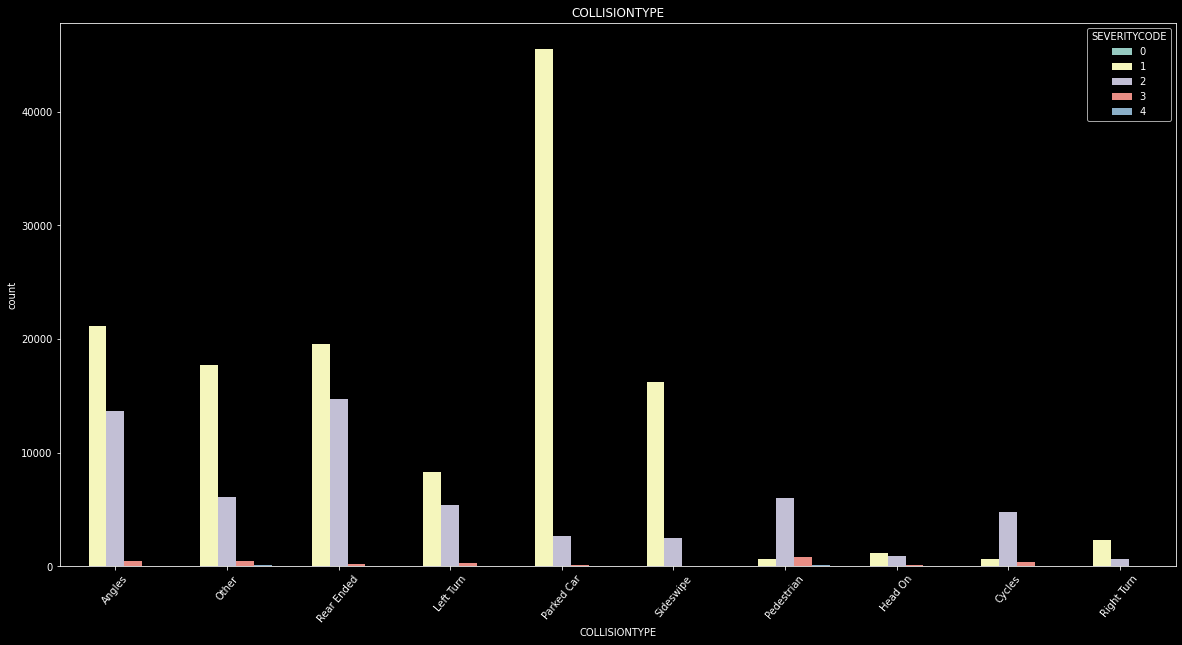

In [114]:
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.countplot('COLLISIONTYPE', hue='SEVERITYCODE', data=df)
ax.legend(title='SEVERITYCODE', loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=50)
ax.set_title('COLLISIONTYPE');

Future predictions will be given only information about the intersection, so choose columns that would have information without an accident happening

In [116]:
df.head()

,Datetime,X,Y,OBJECTID,INCKEY,COLDETKEY,ADDRTYPE,INTKEY,LOCATION,SEVERITYCODE,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INCDATE,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR,latlon_tup,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,2003-10-06 00:00:00,-122.320755,47.608073,909,3663,3663,Intersection,29797.0,BROADWAY AND CHERRY ST,0,Unknown,NaN,0,0,0,0,0,0,0,2003/10/06 00:00:00+00,NaN,NaN,NaN,0,0,0,0,0,1,3279003.0,0,NaN,NaN,0,0,0,"(47.608073467378794, -122.32075479129101)",0.011293,1.786588,0.248892,0.004166
10,2004-01-01 00:00:00,-122.313520,47.601688,9296,22796,22796,Block,NaN,E YESLER WAY BETWEEN 14TH AVE AND 15TH AVE,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (but intersection related),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001029.0,0,NaN,NaN,0,0,0,"(47.6016875604153, -122.31351964524299)",0.085651,1.502844,0.074822,0.023317
11,2004-01-01 00:00:00,-122.337454,47.615057,13901,27177,27177,Intersection,29540.0,7TH AVE AND VIRGINIA ST,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,At Intersection (intersection related),11.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE",0,0,0,0,0,0,4001027.0,0,NaN,NaN,0,0,0,"(47.615056751488396, -122.337454236738)",0.009403,0.999276,0.513238,0.005482
16,2004-01-01 00:00:00,0.000000,0.000000,14794,29248,29248,Unknown,NaN,NaN,0,Unknown,NaN,0,0,0,0,0,0,0,2004/01/01 00:00:00+00,NaN,0.0,NOT ENOUGH INFORMATION / NOT APPLICABLE,0,0,0,0,0,0,4001030.0,0,NaN,NaN,0,0,0,"(0.0, 0.0)",0.000000,0.000000,0.000000,0.000000
30,2004-01-01 00:00:00,-122.360959,47.571594,13167,25538,25538,Block,NaN,WEST SEATTLE BR WB BETWEEN W SEATTLE BR WB OFF RP AND HARBOR AV SW OFF RP,0,Unknown,NaN,0,0,0,2,0,0,0,2004/01/01 00:00:00+00,Mid-Block (not related to intersection),14.0,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",0,0,0,0,0,0,4001028.0,0,NaN,NaN,0,0,0,"(47.5715936116426, -122.360958600635)",0.115034,0.485087,0.635936,0.034460


In [115]:
df.columns

Index(['Datetime', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'ADDRTYPE',
       'INTKEY', 'LOCATION', 'SEVERITYCODE', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INJURIES',
       'SERIOUSINJURIES', 'FATALITIES', 'INCDATE', 'JUNCTIONTYPE',
       'SDOT_COLCODE', 'SDOT_COLDESC', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SDOTCOLNUM',
       'SPEEDING', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY',
       'HITPARKEDCAR', 'latlon_tup', 'bikerack_dist', 'radar_dist',
       't_circles_dist', 'marked_cross_dist'],
      dtype='object')

In [130]:
cols_to_drop = ['Datetime', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'INTKEY', 'LOCATION', 'SEVERITYDESC',
                 'COLLISIONTYPE', 'INCDATE', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM', 
                 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'latlon_tup']

In [139]:
data = df.drop(columns=cols_to_drop)
data.isnull().sum()

ADDRTYPE             0
SEVERITYCODE         0
PERSONCOUNT          0
PEDCOUNT             0
PEDCYLCOUNT          0
VEHCOUNT             0
INJURIES             0
SERIOUSINJURIES      0
FATALITIES           0
INATTENTIONIND       0
UNDERINFL            0
WEATHER              0
ROADCOND             0
LIGHTCOND            0
PEDROWNOTGRNT        0
SPEEDING             0
HITPARKEDCAR         0
bikerack_dist        0
radar_dist           0
t_circles_dist       0
marked_cross_dist    0
dtype: int64

### Model Time: OLS based on SeverityCode category

In [140]:
# OLS requires all numeric columns
data.head()

,ADDRTYPE,SEVERITYCODE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INJURIES,SERIOUSINJURIES,FATALITIES,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,bikerack_dist,radar_dist,t_circles_dist,marked_cross_dist
0,Intersection,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.011293,1.786588,0.248892,0.004166
10,Block,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.085651,1.502844,0.074822,0.023317
11,Intersection,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.009403,0.999276,0.513238,0.005482
16,Unknown,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000
30,Block,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0.115034,0.485087,0.635936,0.034460


In [141]:
data['ADDRTYPE'] = data['ADDRTYPE'].map({'Unknown':0, 'Block':1, 'Intersection':2, 'Alley':3})

In [142]:
y = data.pop('SEVERITYCODE')
X = data

In [149]:
# model = sm.OLS(y, X)
# results = model.fit()
print(results.summary())
print('\n')
print('R-squared: ', results.rsquared)
print('\n')
print(results.pvalues)

                                 OLS Regression Results                                
Dep. Variable:           SEVERITYCODE   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                          1.609e+05
Date:                Tue, 11 Aug 2020   Prob (F-statistic):                        0.00
Time:                        23:13:27   Log-Likelihood:                         -76745.
No. Observations:              220338   AIC:                                  1.535e+05
Df Residuals:                  220318   BIC:                                  1.537e+05
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

### X and Y and train_test_split: INJURIES_OCCURRED

In [167]:
# instead of predicting category of severity code, determined binary: injuries vs no injuries
data['INJURIES_OCCURRED'] = (y >= 2).astype(int)

In [169]:
# drop the other columns indicating injuries
# also drop person count
data[['INJURIES', 'SERIOUSINJURIES', 'FATALITIES', 'INJURIES_OCCURRED']].corr()

,INJURIES,SERIOUSINJURIES,FATALITIES,INJURIES_OCCURRED
INJURIES,1.000000,0.279734,0.067403,0.816980
SERIOUSINJURIES,0.279734,1.000000,0.173780,0.153551
FATALITIES,0.067403,0.173780,1.000000,0.060229
INJURIES_OCCURRED,0.816980,0.153551,0.060229,1.000000


In [179]:
y2 = data.pop('INJURIES_OCCURRED')
x2 = data.drop(columns=['PERSONCOUNT','INJURIES', 'SERIOUSINJURIES', 'FATALITIES'])

In [180]:
X_train, X_test, y_train, y_test = train_test_split(x2,y2)

### Light GBM

In [199]:
# Create dataset for lightgbm
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# specify configuration
params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'num_leaves': 31,
        'learning_rate': 0.05,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
}

gbm = lgb.train(params, 
                lgb_train, 
                num_boost_round=20, 
                valid_sets=lgb_eval, 
                early_stopping_rounds=5)

gbm.save_model('../models/feateng_lgbm.txt')

[1]	valid_0's binary_logloss: 0.582653
Training until validation scores don't improve for 5 rounds
[2]	valid_0's binary_logloss: 0.574991
[3]	valid_0's binary_logloss: 0.566795
[4]	valid_0's binary_logloss: 0.560111
[5]	valid_0's binary_logloss: 0.553606
[6]	valid_0's binary_logloss: 0.547044
[7]	valid_0's binary_logloss: 0.542413
[8]	valid_0's binary_logloss: 0.537137
[9]	valid_0's binary_logloss: 0.532074
[10]	valid_0's binary_logloss: 0.527443
[11]	valid_0's binary_logloss: 0.523504
[12]	valid_0's binary_logloss: 0.51969
[13]	valid_0's binary_logloss: 0.516068
[14]	valid_0's binary_logloss: 0.512666
[15]	valid_0's binary_logloss: 0.509566
[16]	valid_0's binary_logloss: 0.506634
[17]	valid_0's binary_logloss: 0.503938
[18]	valid_0's binary_logloss: 0.50157
[19]	valid_0's binary_logloss: 0.499205
[20]	valid_0's binary_logloss: 0.497233
Did not meet early stopping. Best iteration is:
[20]	valid_0's binary_logloss: 0.497233


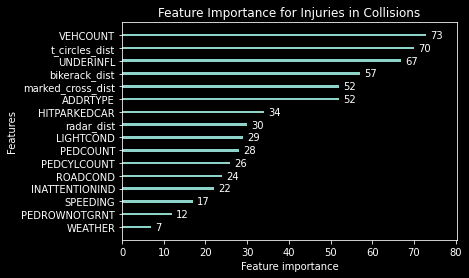

In [205]:
# Get feature importances
lgb.plot_importance(gbm, title="Feature Importance for Injuries in Collisions", grid=False)

# plt.savefig('../plots/feateng_importance_gbm.png')

In [197]:
# Get prediction and AUC score
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
roc_auc_score(y_test, y_pred)

0.7808285198551637

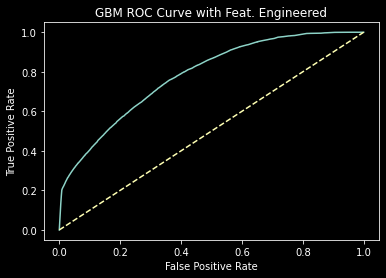

In [207]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.set_title('GBM ROC Curve with Feat. Engineered')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.plot(np.linspace(0,1,100), np.linspace(0,1,100), '--')

# plt.savefig('../plots/feateng_roc_gbm.png')

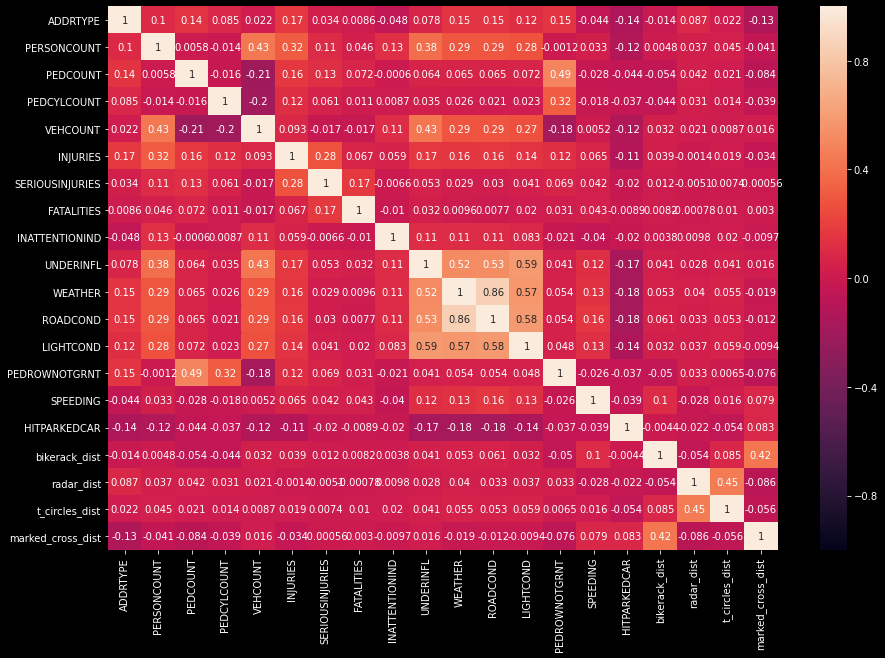

In [208]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.heatmap(data.corr(), annot=True, vmin=-1, vmax=1);

# plt.savefig('../plots/feateng_heatmap.png')

In [193]:
# The average distance of bike racks from a collision site is slightly larger when there are no cyclist involved
data[['bikerack_dist', 'PEDCYLCOUNT']].groupby('PEDCYLCOUNT').mean()

,bikerack_dist
PEDCYLCOUNT,
0,0.107445
1,0.072700
2,0.069377


In [194]:
# The average distance of bike racks from a collision site is slightly larger when there are no cyclist involved
data[['marked_cross_dist', 'PEDCOUNT']].groupby('PEDCOUNT').mean()

,marked_cross_dist
PEDCOUNT,
0,0.055339
1,0.028897
2,0.026996
3,0.028297
4,0.028955
5,0.027862
6,0.020462
